In [1]:
!pip install rdkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 36.8 MB 1.3 MB/s 


In [2]:
from rdkit import Chem
from rdkit.Chem import Draw

In [5]:
#can use rdkit to represent molecules as SMILES
caffeine_smiles = 'CN1C=NC2=C1C(=O)N(C(=O)N2C)C'
mol = Chem.MolFromSmiles(caffeine_smiles)
mol

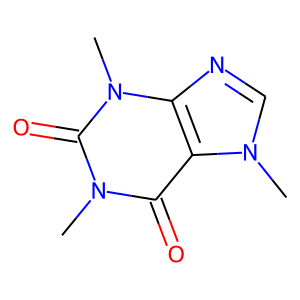

In [9]:
# draw the modecule 
draw = Draw.MolToFile(mol, 'caffeine.png')

from IPython.display import Image
Image(filename='caffeine.png') 

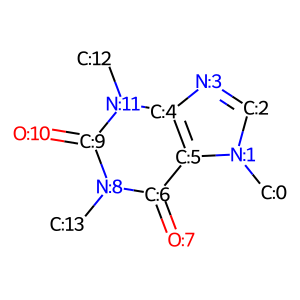

In [10]:
# draw the molecule with property 
for i, atom in enumerate(mol.GetAtoms()):
    atom.SetProp("molAtomMapNumber", str(atom.GetIdx()))
    
Draw.MolToFile(mol, 'caffeine_with_prop.png')
Image(filename='caffeine_with_prop.png') 

In [12]:
# print the atoms of the molecule
for atom in mol.GetAtoms():
    print(atom.GetIdx(),',',
          atom.GetAtomicNum(),',',
          atom.GetIsAromatic(),',',
          atom.GetSymbol())

0 , 6 , False , C
1 , 7 , True , N
2 , 6 , True , C
3 , 7 , True , N
4 , 6 , True , C
5 , 6 , True , C
6 , 6 , True , C
7 , 8 , False , O
8 , 7 , True , N
9 , 6 , True , C
10 , 8 , False , O
11 , 7 , True , N
12 , 6 , False , C
13 , 6 , False , C


In [13]:
# print the bonds of the molecule 
for bond in mol.GetBonds():
    print(bond.GetBeginAtomIdx(),',',
          bond.GetEndAtomIdx(),',',
          bond.GetBondType())

0 , 1 , SINGLE
1 , 2 , AROMATIC
2 , 3 , AROMATIC
3 , 4 , AROMATIC
4 , 5 , AROMATIC
5 , 6 , AROMATIC
6 , 7 , DOUBLE
6 , 8 , AROMATIC
8 , 9 , AROMATIC
9 , 10 , DOUBLE
9 , 11 , AROMATIC
11 , 12 , SINGLE
8 , 13 , SINGLE
5 , 1 , AROMATIC
11 , 4 , AROMATIC


Rdkit supports several fingerprint functions. They can be used in ML models, and/or to calculate similarity between molecules. 

In [14]:
from rdkit.Chem import RDKFingerprint
from rdkit.Chem import rdMolDescriptors

# we need numpy for data type conversion
import numpy as np

In [17]:
# rdkit Fingerprint 
fingerprint_rdk = RDKFingerprint(mol)
print("RDK Fingerprint = ", fingerprint_rdk)

fingerprint_rdk_np = np.array(fingerprint_rdk)
print("RDK Fingerprint in numpy = ", fingerprint_rdk_np)
print("RDK Fingerprint in numpy shape = ", fingerprint_rdk_np.shape)

print()

RDK Fingerprint =  <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f9539ac12b0>
RDK Fingerprint in numpy =  [1 1 0 ... 0 0 1]
RDK Fingerprint in numpy shape =  (2048,)



In [18]:
# Morgan Fingerprint 
fingerprint_morgan = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=2)
print("Morgan Fingerprint = ", fingerprint_morgan)

fingerprint_morgan_np = np.array(fingerprint_morgan)
print("Morgan Fingerprint in numpy : ", fingerprint_morgan_np)
print("Morgan Fingerprint in numpy shape = ", fingerprint_morgan_np.shape)

print()

Morgan Fingerprint =  <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f9539af7e90>
Morgan Fingerprint in numpy :  [0 0 0 ... 0 0 0]
Morgan Fingerprint in numpy shape =  (2048,)



In [19]:
# one-hot encoding of SMILES string

# define SMILES characters 
SMILES_CHARS = [' ',
                '#', '%', '(', ')', '+', '-', '.', '/',
                '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
                '=', '@',
                'A', 'B', 'C', 'F', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P',
                'R', 'S', 'T', 'V', 'X', 'Z',
                '[', '\\', ']',
                'a', 'b', 'c', 'e', 'g', 'i', 'l', 'n', 'o', 'p', 'r', 's',
                't', 'u']
                
# define encoder and decoder 
smi2index = dict( (c,i) for i,c in enumerate( SMILES_CHARS ) )
index2smi = dict( (i,c) for i,c in enumerate( SMILES_CHARS ) )

def smiles_encoder( smiles, maxlen=120 ):
    X = np.zeros( ( maxlen, len( SMILES_CHARS ) ) )
    for i, c in enumerate( smiles ):
        X[i, smi2index[c] ] = 1
    return X

def smiles_decoder( X ):
    smi = ''
    X = X.argmax( axis=-1 )
    for i in X:
        smi += index2smi[ i ]
    return smi

In [21]:
#one-hot encoding for caffeine molecule
caffeine_smiles = 'CN1C=NC2=C1C(=O)N(C(=O)N2C)C'

caffeine_encoding = smiles_encoder(caffeine_smiles)

print(caffeine_encoding)
print(caffeine_encoding.shape) 

print()

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(120, 56)



In [25]:
caffeine_encoding.dtype

dtype('float64')

In [31]:
import networkx as nx #to represent molecules as graphs
import matplotlib.pyplot as plt

In [32]:
# define the function for coverting rdkit object to networkx object      
def mol_to_nx(mol):
    G = nx.Graph()

    for atom in mol.GetAtoms():
        G.add_node(atom.GetIdx(),
                   atomic_num=atom.GetAtomicNum(),
                   is_aromatic=atom.GetIsAromatic(),
                   atom_symbol=atom.GetSymbol())
        
    for bond in mol.GetBonds():
        G.add_edge(bond.GetBeginAtomIdx(),
                   bond.GetEndAtomIdx(),
                   bond_type=bond.GetBondType())
        
    return G

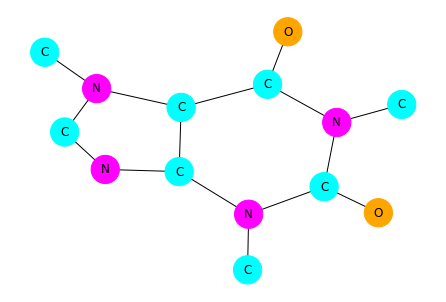

In [34]:
# conver rdkit object to networkx object
caffeine_nx = mol_to_nx(mol)

caffeine_atom = nx.get_node_attributes(caffeine_nx, 'atom_symbol')

color_map = {'C': 'cyan',
             'O': 'orange',
             'N': 'magenta'}  

caffeine_colors = []
for idx in caffeine_nx.nodes():
    if (caffeine_nx.nodes[idx]['atom_symbol'] in color_map):
        caffeine_colors.append(color_map[caffeine_nx.nodes[idx]['atom_symbol']])
    else:
        caffeine_colors.append('gray')
    
nx.draw(caffeine_nx,
        labels=caffeine_atom,
        with_labels = True,
        node_color=caffeine_colors,
        node_size=800)

plt.show()

In [35]:
# print adjacency matrix 
matrix = nx.to_numpy_matrix(caffeine_nx)
print(matrix)

[[0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
  0.000 0.000]
 [1.000 0.000 1.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000
  0.000 0.000]
 [0.000 1.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
  0.000 0.000]
 [0.000 0.000 1.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
  0.000 0.000]
 [0.000 0.000 0.000 1.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000 1.000
  0.000 0.000]
 [0.000 1.000 0.000 0.000 1.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000
  0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 1.000 0.000 1.000 1.000 0.000 0.000 0.000
  0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000
  0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000 1.000 0.000 0.000
  0.000 1.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 1.000 1.000
  0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000
  0.000 0.000]
 [0.000 0.000 0.000 0